## Question 1: Predict the number of order days

**This notebook was developed on Google Colab and all installations, imports, uploads and downloads were made to work on it.**

### Import and install

In [2]:
pip install scikit-optimize xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
# from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GroupKFold
from skopt.space import Real

### Load datasets

In [4]:
from google.colab import files
uploaded = files.upload()

Saving august_total_sales.parquet to august_total_sales.parquet
Saving august_with_missing_order_days.parquet to august_with_missing_order_days.parquet
Saving historical_orders.parquet to historical_orders.parquet


In [5]:
historical_df = pd.read_parquet("historical_orders.parquet", engine='pyarrow')
historical_df.head()

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0


In [6]:
august_partial_df = pd.read_parquet("august_with_missing_order_days.parquet")
august_partial_df.head()

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16


In [7]:
august_forecast_df = pd.read_parquet("august_total_sales.parquet")
august_forecast_df.head()

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14


### Functions

In [8]:
def format_suffix(n):
    if n >= 1_000_000:
        return f'{n/1_000_000:.0f}M'
    elif n >= 1_000:
        return f'{n/1_000:.0f}K'
    else:
        return str(n)

In [9]:
def plot_time_series(data, x_column, y_column, x_label, y_label, title):
  plt.figure(figsize=(10, 5))
  plt.plot(data[x_column], data[y_column], marker='o')
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  for x, y in zip(data[x_column], data[y_column]):
    #plt.text(x, y, str(y), ha='center', va='bottom', fontsize=9)
    #plt.text(x, y, f'{(y/1_000):.0f}K', ha='center', va='bottom', fontsize=9)
    plt.text(x, y, format_suffix(y), ha='center', va='bottom', fontsize=9)

  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [10]:
def label_order_period(day):
    if day <= 10:
        return 1
    elif day <= 20:
        return 2
    else:
        return 3

### Exploratory Data Analysis

In [11]:
historical_df.shape

(8596877, 3)

In [12]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8596877 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype  
---  ------              -----  
 0   account_id          object 
 1   order_date          object 
 2   transaction_amount  float64
dtypes: float64(1), object(2)
memory usage: 262.4+ MB


In [13]:
# Number of null data
historical_df.isnull().sum()

,0
account_id,0
order_date,0
transaction_amount,0


In [14]:
# Data duplicates
historical_df[historical_df.duplicated()]

,account_id,order_date,transaction_amount
2,BR_09607801000194,2021-08-28,11011.20
3,BR_09607801000194,2021-08-28,11011.20
4,BR_09607801000194,2021-08-28,13764.00
5,BR_09607801000194,2021-08-28,13764.00
15,BR_00481601562,2022-06-18,23.00
...,...,...,...
9397072,BR_19491957000106,2022-05-03,22.24
9397073,BR_19491957000106,2022-05-03,22.24
9397074,BR_19491957000106,2022-05-03,22.24
9397076,BR_19491957000106,2022-05-03,22.24


In [15]:
print(f'Number of duplicated: {historical_df.duplicated().sum()}')

Number of duplicated: 841462


In [16]:
# Delete duplicated
historical_df.drop_duplicates(inplace=True)
print(f'Number of duplicated: {historical_df.duplicated().sum()}')

Number of duplicated: 0


In [17]:
historical_df.shape

(7755415, 3)

In [18]:
# Disables scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [19]:
historical_df.describe()

,transaction_amount
count,7755415.00
mean,280.95
std,1176.80
min,-607.50
25%,36.00
50%,89.84
75%,209.80
max,418578.92


In [20]:
print(f'The minimum date is {historical_df.order_date.min()} and maximum date\
 is {historical_df.order_date.max()}.')

The minimum date is 2021-01-02 and maximum date is 2022-07-31.


In [21]:
# Change type of order_date
historical_df['order_date'] = pd.to_datetime(
    historical_df['order_date'], errors='coerce')
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7755415 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   account_id          object        
 1   order_date          datetime64[ns]
 2   transaction_amount  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 236.7+ MB


In [22]:
# Number of unique users
historical_df.account_id.nunique()

47899

In [23]:
# Number of total orders per user per month
order_per_user = historical_df.groupby('account_id')['order_date'].count(
    ).sort_values(ascending = False).reset_index(
        name='total_order')
order_per_user.head(10)

,account_id,total_order
0,BR_33444366000109,5970
1,BR_14517343000132,5573
2,BR_30179280000108,5361
3,BR_37887177000161,5125
4,BR_27873143000164,5020
5,BR_26312477000104,4391
6,BR_27445786000107,4135
7,BR_34760676000103,4060
8,BR_37657197002009,4033
9,BR_55967699000236,3823


In [24]:
order_per_user.total_order.describe()

,total_order
count,47899.00
mean,161.91
std,266.59
min,1.00
25%,22.00
50%,73.00
75%,190.00
max,5970.00


In [25]:
# Create a new column order_month
historical_df['order_month'] = historical_df['order_date'].dt.to_period('M')
historical_df.head(2)

,account_id,order_date,transaction_amount,order_month
0,BR_09607801000194,2021-08-28,11011.20,2021-08
1,BR_09607801000194,2021-08-28,13764.00,2021-08


In [26]:
# Number of total orders per user historically
orders_per_user_month = (historical_df.groupby(['account_id', 'order_month'])
      .size()
      .reset_index(name='monthly_orders'))
orders_per_user_month

,account_id,order_month,monthly_orders
0,BR_00000343803,2021-01,7
1,BR_00000343803,2021-02,4
2,BR_00000343803,2021-03,6
3,BR_00000343803,2021-04,4
4,BR_00000343803,2021-05,8
...,...,...,...
416386,BR_99946866587,2022-05,6
416387,BR_99946866587,2022-06,8
416388,BR_99946866587,2022-07,12
416389,BR_99980878134,2021-05,13


In [27]:
orders_per_user_month.monthly_orders.describe()

,monthly_orders
count,416391.00
mean,18.63
std,21.77
min,1.00
25%,6.00
50%,12.00
75%,23.00
max,710.00


<Axes: ylabel='Frequency'>

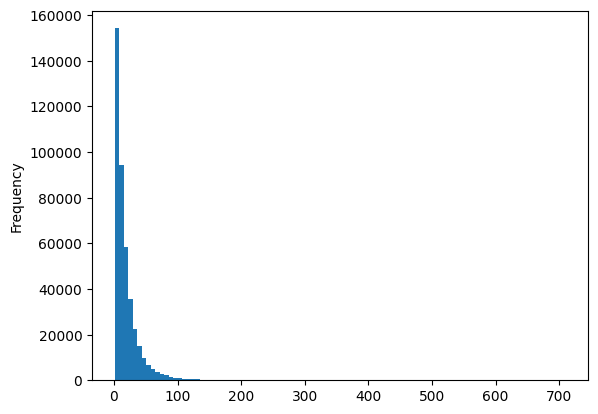

In [28]:
orders_per_user_month['monthly_orders'].plot.hist(bins=100)

<Axes: >

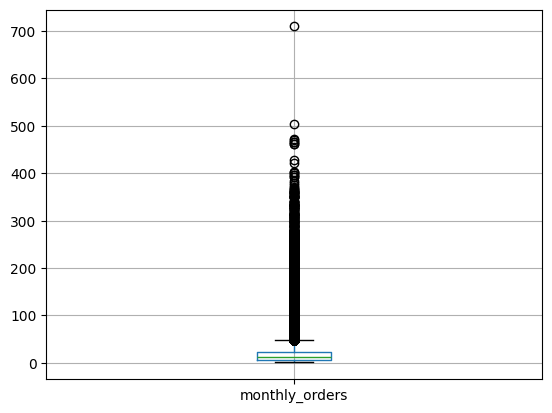

In [29]:
orders_per_user_month.boxplot(column='monthly_orders')

In [30]:
# Number of orders per month
monthly_orders = historical_df.groupby(historical_df['order_date']
    .dt.to_period('M')).size().reset_index(name='total_orders')
monthly_orders

,order_date,total_orders
0,2021-01,281854
1,2021-02,263996
2,2021-03,269064
3,2021-04,262868
4,2021-05,294883
5,2021-06,305589
6,2021-07,332317
7,2021-08,364373
8,2021-09,385784
9,2021-10,550570


In [31]:
monthly_orders['order_date'] = monthly_orders['order_date'].dt.to_timestamp()

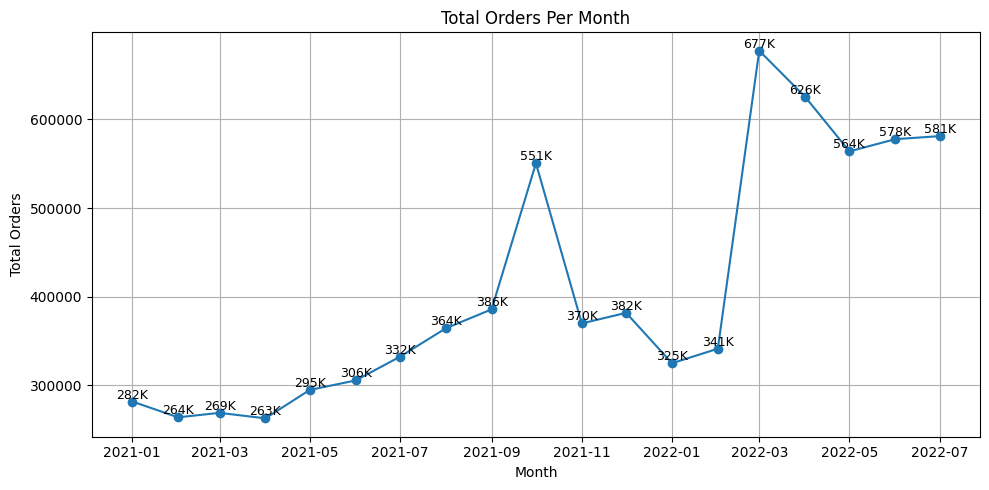

In [32]:
plot_time_series(monthly_orders, 'order_date', 'total_orders', 'Month', 'Total Orders', 'Total Orders Per Month')

In [33]:
# Number of total orders per user per day historically
orders_per_user_day = (historical_df.groupby(['account_id', 'order_date'])
      .size().sort_values(ascending=False)
      .reset_index(name='day_orders'))
orders_per_user_day.head(10)

,account_id,order_date,day_orders
0,BR_37657197003757,2021-12-30,141
1,BR_40666652000184,2022-07-20,129
2,BR_39568816000151,2022-03-24,111
3,BR_37657197003838,2022-01-03,106
4,BR_39477115000107,2022-05-17,100
5,BR_00127427000155,2022-06-11,94
6,BR_39568816000151,2022-02-23,93
7,BR_37657197005024,2021-12-22,89
8,BR_37657197003838,2022-07-05,88
9,BR_21895647000107,2021-11-04,88


In [34]:
orders_per_user_day.day_orders.describe()

,day_orders
count,1428384.00
mean,5.43
std,5.11
min,1.00
25%,2.00
50%,4.00
75%,7.00
max,141.00


<Axes: ylabel='Frequency'>

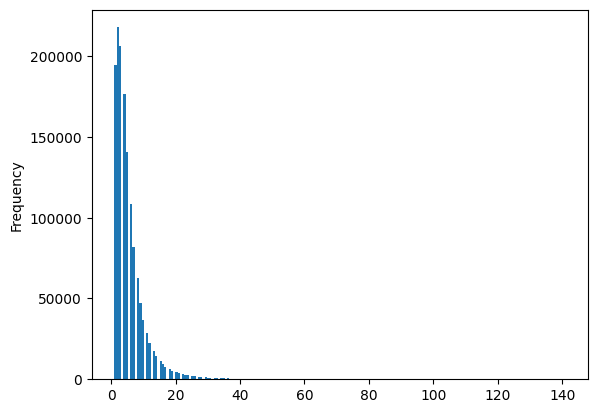

In [35]:
orders_per_user_day['day_orders'].plot.hist(bins=200)

<Axes: >

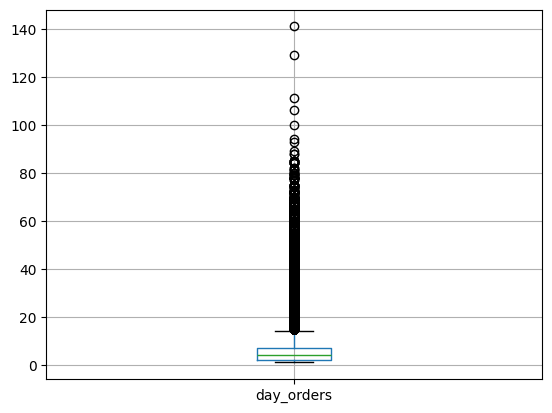

In [36]:
orders_per_user_day.boxplot(column='day_orders')

In [37]:
# Number of distinct days with orders per month historically
distinct_days_per_month = (
    historical_df.groupby('order_month')['order_date']
    .nunique()
    .reset_index(name='distinct_order_days')
)
distinct_days_per_month

,order_month,distinct_order_days
0,2021-01,25
1,2021-02,24
2,2021-03,27
3,2021-04,25
4,2021-05,26
5,2021-06,26
6,2021-07,27
7,2021-08,26
8,2021-09,27
9,2021-10,27


In [38]:
distinct_days_per_month['order_month'] = distinct_days_per_month[
    'order_month'].dt.to_timestamp()

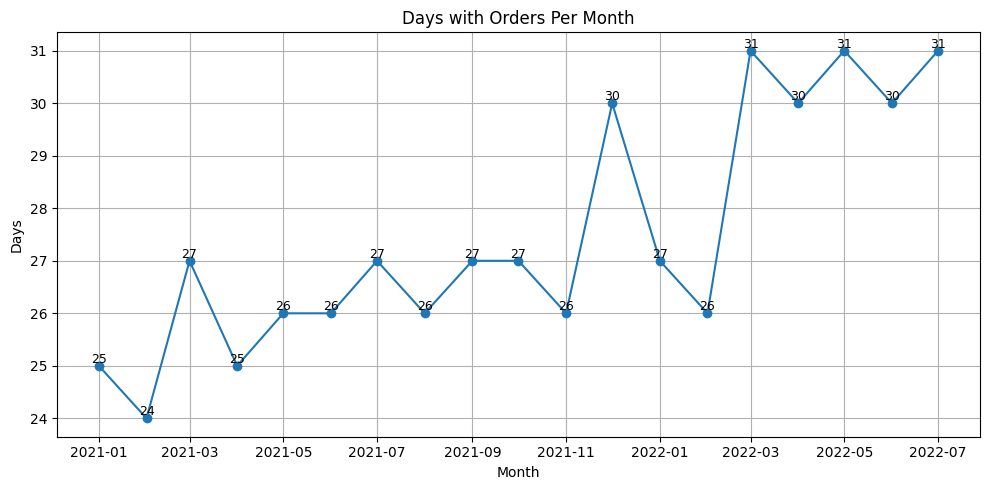

In [39]:
plot_time_series(distinct_days_per_month,
  'order_month', 'distinct_order_days', 'Month',
  'Days', 'Days with Orders Per Month')

In [40]:
historical_df.transaction_amount.describe()

,transaction_amount
count,7755415.00
mean,280.95
std,1176.80
min,-607.50
25%,36.00
50%,89.84
75%,209.80
max,418578.92


In [41]:
# Verify negative numbers in transaction_amount
historical_df[historical_df[
    'transaction_amount']<0].value_counts(
    'transaction_amount').sum()

np.int64(16740)

In [42]:
# Replace negative number with average of total_transaction_amount_august
mean_value = historical_df.loc[historical_df[
  'transaction_amount'] >= 0,
  'transaction_amount'].mean()
historical_df.loc[historical_df['transaction_amount'] < 0,
  'transaction_amount'] = mean_value
historical_df[historical_df[
  'transaction_amount']<0].value_counts(
  'transaction_amount')

,count
transaction_amount,


In [43]:
historical_df.describe()

,order_date,transaction_amount
count,7755415,7755415.00
mean,2021-11-28 22:21:54.619941120,281.77
min,2021-01-02 00:00:00,0.00
25%,2021-07-26 00:00:00,36.36
50%,2021-12-15 00:00:00,90.52
75%,2022-04-19 00:00:00,211.60
max,2022-07-31 00:00:00,418578.92
std,NaN,1176.67


<Axes: >

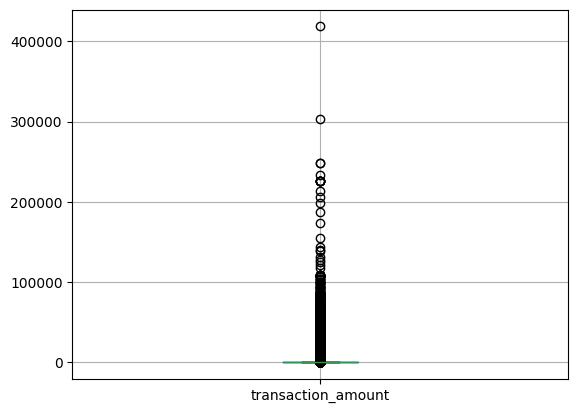

In [44]:
historical_df.boxplot('transaction_amount')

In [45]:
historical_df.head(2)

,account_id,order_date,transaction_amount,order_month
0,BR_09607801000194,2021-08-28,11011.20,2021-08
1,BR_09607801000194,2021-08-28,13764.00,2021-08


In [46]:
# Total transaction amount per month
monthly_transactions_amount = historical_df.groupby('order_month')[
    'transaction_amount'].sum().reset_index(name='total_transactions_amount')
monthly_transactions_amount

,order_month,total_transactions_amount
0,2021-01,93537556.63
1,2021-02,77562704.15
2,2021-03,75484718.14
3,2021-04,76831850.76
4,2021-05,84814918.45
5,2021-06,78221863.89
6,2021-07,86863637.62
7,2021-08,95755875.28
8,2021-09,117842710.11
9,2021-10,149277371.82


In [47]:
monthly_transactions_amount.order_month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 19 entries, 0 to 18
Series name: order_month
Non-Null Count  Dtype    
--------------  -----    
19 non-null     period[M]
dtypes: period[M](1)
memory usage: 284.0 bytes


In [48]:
distinct_days_per_month.order_month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 19 entries, 0 to 18
Series name: order_month
Non-Null Count  Dtype         
--------------  -----         
19 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 284.0 bytes


In [49]:
# Convert order_month to timestamp
monthly_transactions_amount['order_month'] = monthly_transactions_amount['order_month'].dt.to_timestamp()
monthly_transactions_amount.order_month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 19 entries, 0 to 18
Series name: order_month
Non-Null Count  Dtype         
--------------  -----         
19 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 284.0 bytes


In [50]:
# Combine into a single DataFrame
monthly_analysis = pd.merge(
    monthly_transactions_amount,
    distinct_days_per_month,
    on='order_month'
)
monthly_analysis.head(2)

,order_month,total_transactions_amount,distinct_order_days
0,2021-01-01,93537556.63,25
1,2021-02-01,77562704.15,24


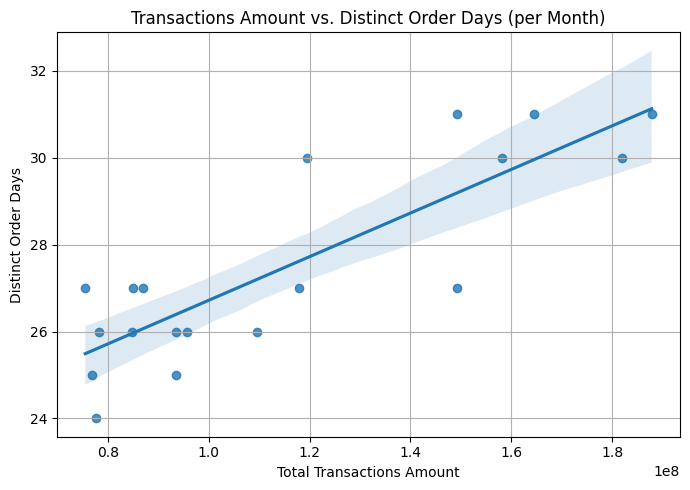

In [51]:
plt.figure(figsize=(7, 5))
sns.regplot(data=monthly_analysis,
    x='total_transactions_amount', y='distinct_order_days')
plt.title('Transactions Amount vs. Distinct Order Days (per Month)')
plt.xlabel('Total Transactions Amount')
plt.ylabel('Distinct Order Days')
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
correlation = monthly_analysis[['total_transactions_amount', 'distinct_order_days']].corr().iloc[0,1]
print(f'Correlation: {correlation:.2f}')

Correlation: 0.84


### Feature Engineering

#### Process historical_df to train and validation set

In [53]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7755415 entries, 0 to 9397113
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   account_id          object        
 1   order_date          datetime64[ns]
 2   transaction_amount  float64       
 3   order_month         period[M]     
dtypes: datetime64[ns](1), float64(1), object(1), period[M](1)
memory usage: 295.8+ MB


In [54]:
historical_df.head(10)

,account_id,order_date,transaction_amount,order_month
0,BR_09607801000194,2021-08-28,11011.20,2021-08
1,BR_09607801000194,2021-08-28,13764.00,2021-08
6,BR_00481601562,2022-06-18,1017.00,2022-06
7,BR_00481601562,2022-06-18,244.20,2022-06
8,BR_00481601562,2022-06-18,23.00,2022-06
9,BR_00481601562,2022-06-18,42.92,2022-06
10,BR_00481601562,2022-06-18,20.88,2022-06
11,BR_00481601562,2022-06-18,46.00,2022-06
12,BR_00481601562,2022-06-18,28.68,2022-06
13,BR_00481601562,2022-06-18,31.68,2022-06


In [198]:
# Drop duplicates to get one row per account_id and order_date
distinct_orders = (
    historical_df[["account_id", "order_date", "order_month"]]
    .drop_duplicates()
    .sort_values(["account_id", "order_date"]).reset_index(
        drop=True
    )
)
distinct_orders.head()

,account_id,order_date,order_month
0,BR_00000343803,2021-01-07,2021-01
1,BR_00000343803,2021-01-14,2021-01
2,BR_00000343803,2021-01-21,2021-01
3,BR_00000343803,2021-01-30,2021-01
4,BR_00000343803,2021-02-11,2021-02


In [199]:
# Count order days so far within the month
distinct_orders["orders_so_far"] = (
    distinct_orders
    .groupby(["account_id", "order_month"])
    .cumcount() + 1
)
distinct_orders.head(15)

,account_id,order_date,order_month,orders_so_far
0,BR_00000343803,2021-01-07,2021-01,1
1,BR_00000343803,2021-01-14,2021-01,2
2,BR_00000343803,2021-01-21,2021-01,3
3,BR_00000343803,2021-01-30,2021-01,4
4,BR_00000343803,2021-02-11,2021-02,1
5,BR_00000343803,2021-02-18,2021-02,2
6,BR_00000343803,2021-03-04,2021-03,1
7,BR_00000343803,2021-03-20,2021-03,2
8,BR_00000343803,2021-03-25,2021-03,3
9,BR_00000343803,2021-04-15,2021-04,1


In [210]:
# Count total order days per (account_id, month)
month_counts = (
    distinct_orders
    .groupby(["account_id", "order_month"])
    .size()
    .rename("total_orders")
    .reset_index()
)
month_counts.head(15)

,account_id,order_month,total_orders
0,BR_00000343803,2021-01,4
1,BR_00000343803,2021-02,2
2,BR_00000343803,2021-03,3
3,BR_00000343803,2021-04,1
4,BR_00000343803,2021-05,3
5,BR_00000343803,2021-06,2
6,BR_00000343803,2021-07,2
7,BR_00000343803,2021-08,2
8,BR_00000343803,2021-09,3
9,BR_00000343803,2021-10,2


In [211]:
# Merge total count back into the main dataframe
target_df = distinct_orders.merge(month_counts, on=["account_id", "order_month"])
target_df.head()

,account_id,order_date,order_month,orders_so_far,total_orders
0,BR_00000343803,2021-01-07,2021-01,1,4
1,BR_00000343803,2021-01-14,2021-01,2,4
2,BR_00000343803,2021-01-21,2021-01,3,4
3,BR_00000343803,2021-01-30,2021-01,4,4
4,BR_00000343803,2021-02-11,2021-02,1,2


In [212]:
# Compute the remaining days after each current_day
target_df["target"] = target_df["total_orders"] - target_df["orders_so_far"]
target_df.drop(columns=["total_orders"], inplace=True)
target_df

,account_id,order_date,order_month,orders_so_far,target
0,BR_00000343803,2021-01-07,2021-01,1,3
1,BR_00000343803,2021-01-14,2021-01,2,2
2,BR_00000343803,2021-01-21,2021-01,3,1
3,BR_00000343803,2021-01-30,2021-01,4,0
4,BR_00000343803,2021-02-11,2021-02,1,1
...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,2021-05,3,0
1428380,BR_99980878134,2021-06-07,2021-06,1,3
1428381,BR_99980878134,2021-06-10,2021-06,2,2
1428382,BR_99980878134,2021-06-12,2021-06,3,1


In [213]:
target_df[target_df['account_id']=='BR_00000343803']

,account_id,order_date,order_month,orders_so_far,target
0,BR_00000343803,2021-01-07,2021-01,1,3
1,BR_00000343803,2021-01-14,2021-01,2,2
2,BR_00000343803,2021-01-21,2021-01,3,1
3,BR_00000343803,2021-01-30,2021-01,4,0
4,BR_00000343803,2021-02-11,2021-02,1,1
5,BR_00000343803,2021-02-18,2021-02,2,0
6,BR_00000343803,2021-03-04,2021-03,1,2
7,BR_00000343803,2021-03-20,2021-03,2,1
8,BR_00000343803,2021-03-25,2021-03,3,0
9,BR_00000343803,2021-04-15,2021-04,1,0


In [214]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   account_id     1428384 non-null  object        
 1   order_date     1428384 non-null  datetime64[ns]
 2   order_month    1428384 non-null  period[M]     
 3   orders_so_far  1428384 non-null  int64         
 4   target         1428384 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1), period[M](1)
memory usage: 54.5+ MB


In [215]:
# Convert order_date is datetime
target_df['order_date'] = pd.to_datetime(target_df['order_date'])
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   account_id     1428384 non-null  object        
 1   order_date     1428384 non-null  datetime64[ns]
 2   order_month    1428384 non-null  period[M]     
 3   orders_so_far  1428384 non-null  int64         
 4   target         1428384 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1), period[M](1)
memory usage: 54.5+ MB


In [59]:
# Group transactions by day per user
grouped_df = (
    historical_df.groupby(['account_id', 'order_date'])
    .agg(transaction_amount=('transaction_amount', 'sum'))
    .reset_index()
)
grouped_df

,account_id,order_date,transaction_amount
0,BR_00000343803,2021-01-07,252.88
1,BR_00000343803,2021-01-14,49.52
2,BR_00000343803,2021-01-21,173.96
3,BR_00000343803,2021-01-30,338.56
4,BR_00000343803,2021-02-11,111.20
...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02
1428380,BR_99980878134,2021-06-07,139.30
1428381,BR_99980878134,2021-06-10,36.96
1428382,BR_99980878134,2021-06-12,76.36


In [60]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   account_id          1428384 non-null  object        
 1   order_date          1428384 non-null  datetime64[ns]
 2   transaction_amount  1428384 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 32.7+ MB


In [61]:
# Merge dataframes
processed_historical_df = pd.merge(grouped_df, target_df,
  on=['account_id','order_date'], how='inner')
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2


In [62]:
# Create a new column with average number of order days per month per user
processed_historical_df['avg_order_days_per_month'] = processed_historical_df.groupby(
  'account_id')['order_date'].transform('nunique')/processed_historical_df.groupby(
  'account_id')['order_month'].transform('nunique')
processed_historical_df.head()

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79


In [63]:
processed_historical_df.avg_order_days_per_month.describe()

,avg_order_days_per_month
count,1428384.00
mean,4.33
std,2.31
min,1.00
25%,2.84
50%,3.79
75%,5.26
max,21.58


In [64]:
# Create a new column to compute the frequency of order days
processed_historical_df.sort_values(by=['account_id', 'order_date'], inplace=True)
processed_historical_df.reset_index(drop=True, inplace=True)
processed_historical_df['days_since_last_order'] = processed_historical_df.groupby('account_id')[
    'order_date'].diff().dt.days
processed_historical_df

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,days_since_last_order
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,NaN
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,7.00
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,7.00
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,9.00
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,12.00
...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02,2021-05,3,0,3.50,4.00
1428380,BR_99980878134,2021-06-07,139.30,2021-06,1,3,3.50,9.00
1428381,BR_99980878134,2021-06-10,36.96,2021-06,2,2,3.50,3.00
1428382,BR_99980878134,2021-06-12,76.36,2021-06,3,1,3.50,2.00


In [65]:
# Create a new column with average days betwenn orders
processed_historical_df['avg_days_between_orders'] = processed_historical_df.groupby('account_id')[
    'days_since_last_order'].transform('mean')
processed_historical_df.drop(columns='days_since_last_order', inplace=True)
processed_historical_df.head()

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,10.94
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,10.94
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,10.94


In [66]:
processed_historical_df.avg_days_between_orders.describe()

,avg_days_between_orders
count,1425110.00
mean,10.44
std,8.54
min,1.00
25%,5.96
50%,8.38
75%,12.58
max,534.00


In [67]:
# Create a new column to compute the typical order days position in the month
processed_historical_df['day_of_month'] = processed_historical_df['order_date'].dt.day
processed_historical_df

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,day_of_month
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,7
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,14
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,10.94,21
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,10.94,30
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,10.94,11
...,...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02,2021-05,3,0,3.50,5.00,29
1428380,BR_99980878134,2021-06-07,139.30,2021-06,1,3,3.50,5.00,7
1428381,BR_99980878134,2021-06-10,36.96,2021-06,2,2,3.50,5.00,10
1428382,BR_99980878134,2021-06-12,76.36,2021-06,3,1,3.50,5.00,12


In [68]:
# Compute average order day per user
avg_day = processed_historical_df.groupby('account_id')['day_of_month'].mean().rename('avg_order_day')
avg_day.head(15)

,avg_order_day
account_id,
BR_00000343803,16.74
BR_00001415930,13.71
BR_00001545205,14.74
BR_00001760106,13.63
BR_00002485176,13.93
BR_00002536340,14.52
BR_00003056503,16.40
BR_00003686108,14.50
BR_00005396352,15.32


In [69]:
avg_day.sort_values()

,avg_order_day
account_id,
BR_31207666823,1.00
BR_01569359000147,1.00
BR_44767073000189,1.00
BR_03191794190,1.00
BR_41693123000132,1.00
...,...
BR_28751317000189,31.00
BR_05985729613,31.00
BR_11686700000106,31.00


In [70]:
# Create labels of order days position in the month
avg_day_period = avg_day.apply(label_order_period).rename('typical_order_period')
avg_day_period.head(15)

,typical_order_period
account_id,
BR_00000343803,2
BR_00001415930,2
BR_00001545205,2
BR_00001760106,2
BR_00002485176,2
BR_00002536340,2
BR_00003056503,2
BR_00003686108,2
BR_00005396352,2


In [71]:
avg_day_period.sort_values()

,typical_order_period
account_id,
BR_01794233121,1
BR_01805148737,1
BR_01812402708,1
BR_01771593326,1
BR_01780814429,1
...,...
BR_31452651809,3
BR_15418386611,3
BR_12928858000108,3


In [72]:
# Merge labels of typical order period back into original dataframe
processed_historical_df = processed_historical_df.merge(avg_day_period, on='account_id', how='left')
processed_historical_df.drop(columns='day_of_month',inplace=True)
processed_historical_df

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,10.94,2
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,10.94,2
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,10.94,2
...,...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02,2021-05,3,0,3.50,5.00,2
1428380,BR_99980878134,2021-06-07,139.30,2021-06,1,3,3.50,5.00,2
1428381,BR_99980878134,2021-06-10,36.96,2021-06,2,2,3.50,5.00,2
1428382,BR_99980878134,2021-06-12,76.36,2021-06,3,1,3.50,5.00,2


In [73]:
processed_historical_df[
    processed_historical_df['account_id'] == 'BR_00008414122']

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
288,BR_00008414122,2021-10-30,455.62,2021-10,1,0,1.00,NaN,3


In [74]:
processed_historical_df[
    processed_historical_df['account_id'] == 'BR_08141858432']

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
330824,BR_08141858432,2021-01-06,326.70,2021-01,1,1,2.00,3.00,1
330825,BR_08141858432,2021-01-09,95.00,2021-01,2,0,2.00,3.00,1


In [75]:
processed_historical_df['avg_days_between_orders']= processed_historical_df[
    'avg_days_between_orders'].fillna(0)
processed_historical_df[
    processed_historical_df['account_id'] == 'BR_00008414122']

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
288,BR_00008414122,2021-10-30,455.62,2021-10,1,0,1.00,0.00,3


In [76]:
processed_historical_df.isnull().sum()

,0
account_id,0
order_date,0
transaction_amount,0
order_month,0
orders_so_far,0
target,0
avg_order_days_per_month,0
avg_days_between_orders,0
typical_order_period,0


In [77]:
processed_historical_df['total_transaction_amount_month'] = processed_historical_df.groupby([
    'account_id', 'order_month'])['transaction_amount'].transform('sum')
processed_historical_df.head()

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,total_transaction_amount_month
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2,814.92
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2,814.92
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,10.94,2,814.92
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,10.94,2,814.92
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,10.94,2,484.76


In [78]:
# Create column of day of month
processed_historical_df["day"] = processed_historical_df[
    "order_date"].dt.day
processed_historical_df['day'] = processed_historical_df['day'].astype('Int64')
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,total_transaction_amount_month,day
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2,814.92,7
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2,814.92,14


In [79]:
# Create column of month
processed_historical_df["month"] = processed_historical_df[
    "order_date"].dt.month
processed_historical_df['month'] = processed_historical_df['month'].astype('Int64')
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,total_transaction_amount_month,day,month
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2,814.92,7,1
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2,814.92,14,1


In [80]:
# Create column of year
processed_historical_df["year"] = processed_historical_df[
    "order_date"].dt.year
processed_historical_df['year'] = processed_historical_df['year'].astype('Int64')
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,total_transaction_amount_month,day,month,year
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2,814.92,7,1,2021
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2,814.92,14,1,2021


In [81]:
processed_historical_df.drop(columns=[
    'order_month'], inplace=True)
processed_historical_df

,account_id,order_date,transaction_amount,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,total_transaction_amount_month,day,month,year
0,BR_00000343803,2021-01-07,252.88,1,3,2.79,10.94,2,814.92,7,1,2021
1,BR_00000343803,2021-01-14,49.52,2,2,2.79,10.94,2,814.92,14,1,2021
2,BR_00000343803,2021-01-21,173.96,3,1,2.79,10.94,2,814.92,21,1,2021
3,BR_00000343803,2021-01-30,338.56,4,0,2.79,10.94,2,814.92,30,1,2021
4,BR_00000343803,2021-02-11,111.20,1,1,2.79,10.94,2,484.76,11,2,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02,3,0,3.50,5.00,2,408.25,29,5,2021
1428380,BR_99980878134,2021-06-07,139.30,1,3,3.50,5.00,2,325.56,7,6,2021
1428381,BR_99980878134,2021-06-10,36.96,2,2,3.50,5.00,2,325.56,10,6,2021
1428382,BR_99980878134,2021-06-12,76.36,3,1,3.50,5.00,2,325.56,12,6,2021


In [82]:
processed_historical_df.columns

Index(['account_id', 'order_date', 'transaction_amount', 'orders_so_far',
       'target', 'avg_order_days_per_month', 'avg_days_between_orders',
       'typical_order_period', 'total_transaction_amount_month', 'day',
       'month', 'year'],
      dtype='object')

In [83]:
processed_historical_df = processed_historical_df[[
    'account_id', 'order_date','day','month', 'year', 'transaction_amount',
    'total_transaction_amount_month','avg_order_days_per_month',
    'avg_days_between_orders','typical_order_period', 'orders_so_far',
    'target'
]]
processed_historical_df.head(2)

,account_id,order_date,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far,target
0,BR_00000343803,2021-01-07,7,1,2021,252.88,814.92,2.79,10.94,2,1,3
1,BR_00000343803,2021-01-14,14,1,2021,49.52,814.92,2.79,10.94,2,2,2


In [84]:
processed_historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 12 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   account_id                      1428384 non-null  object        
 1   order_date                      1428384 non-null  datetime64[ns]
 2   day                             1428384 non-null  Int64         
 3   month                           1428384 non-null  Int64         
 4   year                            1428384 non-null  Int64         
 5   transaction_amount              1428384 non-null  float64       
 6   total_transaction_amount_month  1428384 non-null  float64       
 7   avg_order_days_per_month        1428384 non-null  float64       
 8   avg_days_between_orders         1428384 non-null  float64       
 9   typical_order_period            1428384 non-null  int64         
 10  orders_so_far                   1428384 no

#### Process august_forecast_df and august_partial_df

In [85]:
august_forecast_df.head(2)

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98


In [86]:
august_forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       32944 non-null  object 
 1   total_transaction_amount_august  32944 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.9+ KB


In [87]:
august_forecast_df.duplicated().sum()

np.int64(0)

In [88]:
august_partial_df.head(2)

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52


In [89]:
august_partial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317735 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   account_id          317735 non-null  object 
 1   order_date          304297 non-null  object 
 2   transaction_amount  304297 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB


In [90]:
august_partial_df.duplicated().sum()

np.int64(26418)

In [91]:
# Delete duplicated
august_partial_df.drop_duplicates(inplace=True)
august_partial_df.duplicated().sum()

np.int64(0)

In [92]:
# Convert order_date is datetime
august_partial_df['order_date'] = pd.to_datetime(august_partial_df['order_date'])
august_partial_df.order_date.info()

<class 'pandas.core.series.Series'>
Index: 291317 entries, 0 to 317734
Series name: order_date
Non-Null Count   Dtype         
--------------   -----         
277879 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.4 MB


In [93]:
# Group transactions by day per user
grouped_august_partial_df = (
    august_partial_df.groupby(['account_id', 'order_date'])
    .agg(transaction_amount=('transaction_amount', 'sum'),)
    .reset_index()
)
grouped_august_partial_df.head(2)

,account_id,order_date,transaction_amount
0,BR_00002485176,2022-08-06,44.00
1,BR_00002485176,2022-08-13,283.98


In [94]:
grouped_august_partial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43927 entries, 0 to 43926
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_id          43927 non-null  object        
 1   order_date          43927 non-null  datetime64[ns]
 2   transaction_amount  43927 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.0+ MB


In [95]:
august_partial_df.account_id.nunique()

32944

In [96]:
grouped_august_partial_df.account_id.nunique()

19506

In [97]:
# Get unique account_ids
account_ids_aug = august_partial_df[['account_id']].drop_duplicates()
# Left join to preserve all account_ids
grouped_august_df = (
    account_ids_aug
    .merge(grouped_august_partial_df, on='account_id', how='left')
)
grouped_august_df.head(2)

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,97.08
1,BR_09532176632,2022-08-04,156.54


In [98]:
grouped_august_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57365 entries, 0 to 57364
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_id          57365 non-null  object        
 1   order_date          43927 non-null  datetime64[ns]
 2   transaction_amount  43927 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.3+ MB


In [99]:
grouped_august_df.account_id.nunique()

32944

In [100]:
august_df = pd.merge(grouped_august_df,august_forecast_df,
  on='account_id', how='left')
august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august
0,BR_09532176632,2022-08-03,97.08,2011.36
1,BR_09532176632,2022-08-04,156.54,2011.36


In [101]:
august_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57365 entries, 0 to 57364
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   account_id                       57365 non-null  object        
 1   order_date                       43927 non-null  datetime64[ns]
 2   transaction_amount               43927 non-null  float64       
 3   total_transaction_amount_august  57365 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.8+ MB


In [102]:
# Verify negative numbers in transaction_amount
august_df[august_df['transaction_amount']<0].value_counts(
    'transaction_amount')

,count
transaction_amount,
-99.00,26
-57.02,1


In [103]:
# Replace negative number with average of transaction_amount
mean_value_aug = august_df.loc[august_df[
  'transaction_amount'] >= 0,
  'transaction_amount'].mean()
august_df.loc[august_df['transaction_amount'] < 0,
  'transaction_amount'] = mean_value_aug
august_df[august_df[
  'transaction_amount']<0].value_counts(
  'transaction_amount')

,count
transaction_amount,


In [104]:
# Verify negative numbers in total_transaction_amount_august
august_df[august_df[
    'total_transaction_amount_august']<0].value_counts(
        'total_transaction_amount_august')

,count
total_transaction_amount_august,
-99.00,21
-198.00,11
-297.00,10
-396.00,7
-9108.00,6
...,...
-9.26,1
-6.30,1
-6.98,1


In [105]:
# Replace negative number with average of total_transaction_amount_august
mean_value_aug = august_df.loc[august_df[
  'total_transaction_amount_august'] >= 0,
  'total_transaction_amount_august'].mean()
august_df.loc[august_df['total_transaction_amount_august'] < 0,
  'total_transaction_amount_august'] = mean_value_aug
august_df[august_df[
  'total_transaction_amount_august']<0].value_counts(
  'total_transaction_amount_august')

,count
total_transaction_amount_august,


In [106]:
august_df.describe()

,order_date,transaction_amount,total_transaction_amount_august
count,43927,43927.00,57365.00
mean,2022-08-09 04:25:04.350399488,1832.43,12980.29
min,2022-08-01 00:00:00,0.00,0.00
25%,2022-08-03 00:00:00,284.30,984.16
50%,2022-08-08 00:00:00,658.90,2799.31
75%,2022-08-15 00:00:00,1548.11,7810.55
max,2022-08-30 00:00:00,453915.44,2638720.17
std,NaN,6053.31,79405.50


In [107]:
august_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57365 entries, 0 to 57364
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   account_id                       57365 non-null  object        
 1   order_date                       43927 non-null  datetime64[ns]
 2   transaction_amount               43927 non-null  float64       
 3   total_transaction_amount_august  57365 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.8+ MB


In [108]:
# Remove rows where order_date is missing to copute orders so far
valid_august_df = august_df[august_df['order_date'].notna()]

In [109]:
# Compute cumulative count of unique order days per user to create orders_so_far
august_orders = valid_august_df.sort_values(by=['account_id', 'order_date'])
august_orders['orders_so_far'] = august_orders.groupby('account_id').cumcount() + 1
august_orders.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,orders_so_far
26930,BR_00002485176,2022-08-06,44.00,511.48,1
26931,BR_00002485176,2022-08-13,283.98,511.48,2


In [110]:
# Merge this back to add new column orders_so_far
processed_august_df = august_df.merge(
    august_orders[['account_id', 'order_date', 'orders_so_far']],
    on=['account_id', 'order_date'],
    how='left'
)
processed_august_df['orders_so_far'] = processed_august_df['orders_so_far'].fillna(0).astype(int)
processed_august_df

,account_id,order_date,transaction_amount,total_transaction_amount_august,orders_so_far
0,BR_09532176632,2022-08-03,97.08,2011.36,1
1,BR_09532176632,2022-08-04,156.54,2011.36,2
2,BR_09532176632,2022-08-08,49.80,2011.36,3
3,BR_09532176632,2022-08-09,21.72,2011.36,4
4,BR_09532176632,2022-08-11,350.50,2011.36,5
...,...,...,...,...,...
57360,BR_30398656000175,NaT,NaN,854.40,0
57361,BR_01248390377,NaT,NaN,130.30,0
57362,BR_03803067863,NaT,NaN,90.33,0
57363,BR_49558358487,NaT,NaN,559.20,0


In [111]:
# Get features to complete august_df for test
historical_features = processed_historical_df[
    ['account_id', 'avg_order_days_per_month',
    'avg_days_between_orders', 'typical_order_period'
    ]].drop_duplicates().copy()
historical_features.head(2)

,account_id,avg_order_days_per_month,avg_days_between_orders,typical_order_period
0,BR_00000343803,2.79,10.94,2
53,BR_00001415930,2.33,14.00,2


In [112]:
historical_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47899 entries, 0 to 1428377
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_id                47899 non-null  object 
 1   avg_order_days_per_month  47899 non-null  float64
 2   avg_days_between_orders   47899 non-null  float64
 3   typical_order_period      47899 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ MB


In [113]:
# Merge to add features into august_df
processed_august_df = processed_august_df.merge(historical_features, on='account_id', how='left')
processed_august_df

,account_id,order_date,transaction_amount,total_transaction_amount_august,orders_so_far,avg_order_days_per_month,avg_days_between_orders,typical_order_period
0,BR_09532176632,2022-08-03,97.08,2011.36,1,2.14,19.50,2.00
1,BR_09532176632,2022-08-04,156.54,2011.36,2,2.14,19.50,2.00
2,BR_09532176632,2022-08-08,49.80,2011.36,3,2.14,19.50,2.00
3,BR_09532176632,2022-08-09,21.72,2011.36,4,2.14,19.50,2.00
4,BR_09532176632,2022-08-11,350.50,2011.36,5,2.14,19.50,2.00
...,...,...,...,...,...,...,...,...
57360,BR_30398656000175,NaT,NaN,854.40,0,1.88,17.94,2.00
57361,BR_01248390377,NaT,NaN,130.30,0,1.71,25.45,2.00
57362,BR_03803067863,NaT,NaN,90.33,0,2.00,24.82,2.00
57363,BR_49558358487,NaT,NaN,559.20,0,1.62,27.55,2.00


In [114]:
# Convert into int as same of processed_historical_df
processed_august_df['typical_order_period'] = processed_august_df[
    'typical_order_period'].astype('Int64')
processed_august_df.typical_order_period.info()

<class 'pandas.core.series.Series'>
RangeIndex: 57365 entries, 0 to 57364
Series name: typical_order_period
Non-Null Count  Dtype
--------------  -----
55929 non-null  Int64
dtypes: Int64(1)
memory usage: 504.3 KB


In [115]:
# Create column of day of month
processed_august_df["day"] = processed_august_df[
    "order_date"].dt.day
processed_august_df['day'] = processed_august_df['day'].astype('Int64')
processed_august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,orders_so_far,avg_order_days_per_month,avg_days_between_orders,typical_order_period,day
0,BR_09532176632,2022-08-03,97.08,2011.36,1,2.14,19.50,2,3
1,BR_09532176632,2022-08-04,156.54,2011.36,2,2.14,19.50,2,4


In [116]:
# Create column of month
processed_august_df["month"] = processed_august_df[
    "order_date"].dt.month
processed_august_df['month'] = processed_august_df['month'].astype('Int64')
processed_august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,orders_so_far,avg_order_days_per_month,avg_days_between_orders,typical_order_period,day,month
0,BR_09532176632,2022-08-03,97.08,2011.36,1,2.14,19.50,2,3,8
1,BR_09532176632,2022-08-04,156.54,2011.36,2,2.14,19.50,2,4,8


In [117]:
# Create column of year
processed_august_df["year"] = processed_august_df[
    "order_date"].dt.year
processed_august_df['year'] = processed_august_df['year'].astype('Int64')
processed_august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,orders_so_far,avg_order_days_per_month,avg_days_between_orders,typical_order_period,day,month,year
0,BR_09532176632,2022-08-03,97.08,2011.36,1,2.14,19.50,2,3,8,2022
1,BR_09532176632,2022-08-04,156.54,2011.36,2,2.14,19.50,2,4,8,2022


In [118]:
processed_august_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57365 entries, 0 to 57364
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   account_id                       57365 non-null  object        
 1   order_date                       43927 non-null  datetime64[ns]
 2   transaction_amount               43927 non-null  float64       
 3   total_transaction_amount_august  57365 non-null  float64       
 4   orders_so_far                    57365 non-null  int64         
 5   avg_order_days_per_month         55929 non-null  float64       
 6   avg_days_between_orders          55929 non-null  float64       
 7   typical_order_period             55929 non-null  Int64         
 8   day                              43927 non-null  Int64         
 9   month                            43927 non-null  Int64         
 10  year                             43927 non-null  Int64    

In [119]:
processed_historical_df.columns

Index(['account_id', 'order_date', 'day', 'month', 'year',
       'transaction_amount', 'total_transaction_amount_month',
       'avg_order_days_per_month', 'avg_days_between_orders',
       'typical_order_period', 'orders_so_far', 'target'],
      dtype='object')

In [120]:
# Rename column to set the structure as processed_historical_df
processed_august_df.rename(columns={
  'total_transaction_amount_august': 'total_transaction_amount_month'},
  inplace=True)
processed_august_df.columns

Index(['account_id', 'order_date', 'transaction_amount',
       'total_transaction_amount_month', 'orders_so_far',
       'avg_order_days_per_month', 'avg_days_between_orders',
       'typical_order_period', 'day', 'month', 'year'],
      dtype='object')

In [121]:
# Reorder columns to set the structure as processed_historical_df
processed_august_df = processed_august_df[[
    'account_id', 'order_date','day', 'month', 'year', 'transaction_amount',
    'total_transaction_amount_month', 'avg_order_days_per_month',
    'avg_days_between_orders', 'typical_order_period', 'orders_so_far']]
processed_august_df.head(2)

,account_id,order_date,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far
0,BR_09532176632,2022-08-03,3,8,2022,97.08,2011.36,2.14,19.50,2,1
1,BR_09532176632,2022-08-04,4,8,2022,156.54,2011.36,2.14,19.50,2,2


In [122]:
processed_august_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57365 entries, 0 to 57364
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   account_id                      57365 non-null  object        
 1   order_date                      43927 non-null  datetime64[ns]
 2   day                             43927 non-null  Int64         
 3   month                           43927 non-null  Int64         
 4   year                            43927 non-null  Int64         
 5   transaction_amount              43927 non-null  float64       
 6   total_transaction_amount_month  57365 non-null  float64       
 7   avg_order_days_per_month        55929 non-null  float64       
 8   avg_days_between_orders         55929 non-null  float64       
 9   typical_order_period            55929 non-null  Int64         
 10  orders_so_far                   57365 non-null  int64         
dtypes:

In [123]:
processed_historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 12 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   account_id                      1428384 non-null  object        
 1   order_date                      1428384 non-null  datetime64[ns]
 2   day                             1428384 non-null  Int64         
 3   month                           1428384 non-null  Int64         
 4   year                            1428384 non-null  Int64         
 5   transaction_amount              1428384 non-null  float64       
 6   total_transaction_amount_month  1428384 non-null  float64       
 7   avg_order_days_per_month        1428384 non-null  float64       
 8   avg_days_between_orders         1428384 non-null  float64       
 9   typical_order_period            1428384 non-null  int64         
 10  orders_so_far                   1428384 no

### Prepare train, validation and test sets

#### Train and validation sets

In [124]:
# Sort by order_date to time-based split
historical_sorted_df = processed_historical_df.sort_values(
    'order_date').reset_index(drop=True)
historical_sorted_df

,account_id,order_date,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far,target
0,BR_50378490478,2021-01-02,2,1,2021,109.80,329.40,2.82,10.55,2,1,2
1,BR_49658982000100,2021-01-02,2,1,2021,1185.44,4414.88,3.42,8.92,2,1,4
2,BR_10334493000150,2021-01-02,2,1,2021,310.00,672.00,1.35,25.73,2,1,2
3,BR_27045714300,2021-01-02,2,1,2021,297.07,677.11,1.30,36.75,2,1,1
4,BR_34506811000180,2021-01-02,2,1,2021,107.80,4470.48,3.47,9.83,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1428379,BR_46182036842,2022-07-31,31,7,2022,253.20,580.40,2.67,11.27,2,3,0
1428380,BR_62450190449,2022-07-31,31,7,2022,1294.86,7662.27,6.16,4.96,2,6,0
1428381,BR_60000821934,2022-07-31,31,7,2022,408.14,1797.71,3.26,9.39,2,6,0
1428382,BR_46441741000109,2022-07-31,31,7,2022,457.48,954.88,3.00,11.00,3,3,0


In [125]:
# Define features and target
features = ['day', 'month', 'year','transaction_amount',
  'total_transaction_amount_month',
  'avg_order_days_per_month', 'avg_days_between_orders',
  'typical_order_period', 'orders_so_far']
target = 'target'

In [126]:
# Split based on a specific date
split_date = '2022-04-01'
train_data = historical_sorted_df[
    historical_sorted_df['order_date'] < split_date].reset_index(drop=True)
val_data = historical_sorted_df[
    historical_sorted_df['order_date'] >= split_date].reset_index(drop=True)
print(f'order_date maximum in train_data: {train_data.order_date.max()}\
  order_date minimum in val_data: {val_data.order_date.min()}')

order_date maximum in train_data: 2022-03-31 00:00:00  order_date minimum in val_data: 2022-04-01 00:00:00


In [127]:
# Keep account_id to fit into tunel model
account_ids_train = train_data['account_id']
account_ids_train.head(2)

,account_id
0,BR_50378490478
1,BR_49658982000100


In [128]:
X_train = train_data[features]
X_train.head(2)

,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far
0,2,1,2021,109.80,329.40,2.82,10.55,2,1
1,2,1,2021,1185.44,4414.88,3.42,8.92,2,1


In [129]:
y_train = train_data[target]
y_train.head(2)

,target
0,2
1,4


In [130]:
X_val = val_data[features]
X_val.head(2)

,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far
0,1,4,2022,1577.75,8724.51,5.74,5.28,2,1
1,1,4,2022,1723.80,4150.58,3.00,16.47,2,1


In [131]:
y_val = val_data[target]
y_val.head(2)

,target
0,9
1,3


#### Test set

In [132]:
processed_august_df.account_id.nunique()

32944

In [133]:
# Sort by order_date to time-based split
august_sorted_df = processed_august_df.sort_values('order_date').reset_index(
    drop=True
)
august_sorted_df

,account_id,order_date,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far
0,BR_04794747101,2022-08-01,1,8,2022,3887.27,18011.42,4.00,10.63,2,1
1,BR_86544809551,2022-08-01,1,8,2022,307.89,7173.50,3.00,14.47,2,1
2,BR_42671910000146,2022-08-01,1,8,2022,767.47,3258.36,3.33,8.38,2,1
3,BR_29856119000142,2022-08-01,1,8,2022,2626.80,22519.85,7.84,3.88,2,1
4,BR_17261661009987,2022-08-01,1,8,2022,1232.40,17524.49,9.84,3.08,2,1
...,...,...,...,...,...,...,...,...,...,...,...
57360,BR_30398656000175,NaT,<NA>,<NA>,<NA>,NaN,854.40,1.88,17.94,2,0
57361,BR_01248390377,NaT,<NA>,<NA>,<NA>,NaN,130.30,1.71,25.45,2,0
57362,BR_03803067863,NaT,<NA>,<NA>,<NA>,NaN,90.33,2.00,24.82,2,0
57363,BR_49558358487,NaT,<NA>,<NA>,<NA>,NaN,559.20,1.62,27.55,2,0


In [134]:
august_sorted_df[august_sorted_df['account_id']=='BR_86544809551']

,account_id,order_date,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far
1,BR_86544809551,2022-08-01,1,8,2022,307.89,7173.50,3.00,14.47,2,1
7026,BR_86544809551,2022-08-02,2,8,2022,974.40,7173.50,3.00,14.47,2,2
8324,BR_86544809551,2022-08-03,3,8,2022,177.35,7173.50,3.00,14.47,2,3
24780,BR_86544809551,2022-08-09,9,8,2022,1752.57,7173.50,3.00,14.47,2,4


In [135]:
# Save account_ids separately to reattach predictions later
account_ids = august_sorted_df['account_id'].copy()
account_ids.head(2)

,account_id
0,BR_04794747101
1,BR_86544809551


In [136]:
X_test = processed_august_df[features]
X_test.head(2)

,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far
0,3,8,2022,97.08,2011.36,2.14,19.50,2,1
1,4,8,2022,156.54,2011.36,2.14,19.50,2,2


### Train the model

##### Version 1

In [137]:
# Define eval_set with training and validation data
eval_set = [(X_train, y_train), (X_val, y_val)]
evals_result = {}

In [138]:
model_v1 = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42,
    eval_metric='mae')
model_v1.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True,
)

[0]	validation_0-mae:1.49283	validation_1-mae:1.42011
[1]	validation_0-mae:1.39265	validation_1-mae:1.32854
[2]	validation_0-mae:1.30323	validation_1-mae:1.24723
[3]	validation_0-mae:1.22355	validation_1-mae:1.17503
[4]	validation_0-mae:1.15306	validation_1-mae:1.11150
[5]	validation_0-mae:1.09058	validation_1-mae:1.05547
[6]	validation_0-mae:1.03550	validation_1-mae:1.00675
[7]	validation_0-mae:0.98668	validation_1-mae:0.96320
[8]	validation_0-mae:0.94588	validation_1-mae:0.92751
[9]	validation_0-mae:0.90980	validation_1-mae:0.89579
[10]	validation_0-mae:0.87913	validation_1-mae:0.86821
[11]	validation_0-mae:0.85144	validation_1-mae:0.84312
[12]	validation_0-mae:0.82826	validation_1-mae:0.82257
[13]	validation_0-mae:0.80891	validation_1-mae:0.80523
[14]	validation_0-mae:0.79071	validation_1-mae:0.78894
[15]	validation_0-mae:0.77516	validation_1-mae:0.77580
[16]	validation_0-mae:0.76116	validation_1-mae:0.76322
[17]	validation_0-mae:0.74788	validation_1-mae:0.75179
[18]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [139]:
# Get evaluation results
evals_result_v1 = model_v1.evals_result()

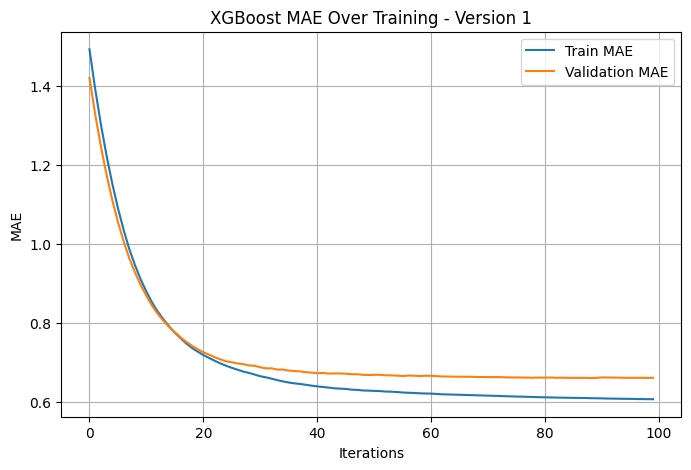

In [140]:
# Plot MAE for training and validation
epochs = len(evals_result_v1['validation_0']['mae'])
x_axis = range(epochs)

plt.figure(figsize=(8,5))
plt.plot(x_axis, evals_result_v1['validation_0']['mae'], label='Train MAE')
plt.plot(x_axis, evals_result_v1['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('XGBoost MAE Over Training - Version 1')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
# Last validation MAE
last_val_mae = evals_result_v1['validation_1']['mae'][-1]
print(f"Last Validation MAE: {last_val_mae}")

Last Validation MAE: 0.6607865106396612


##### Version 2 with hyperparameter tuning

In [145]:
# Use GroupKFold to split because data is time-dependent and avoid data leakage
gkf = GroupKFold(n_splits=3)

In [148]:
xgb = XGBRegressor(
    objective = "count:poisson", tree_method = "hist", n_jobs = 4,
    random_state= 42)

# Define the search space
search_space = {
    "n_estimators": (100, 500),
    "learning_rate": Real(0.01, 0.2, prior="log-uniform"),
    "max_depth": (3, 10),
    "subsample": (0.6, 1.0),
    "colsample_bytree": (0.6, 1.0),
}

In [149]:
opt = BayesSearchCV(
    estimator = xgb,
    search_spaces = search_space,
    n_iter = 16,
    scoring = "neg_mean_absolute_error",
    cv = gkf,
    n_jobs = 1,
    verbose = 2,
    random_state = 42
)

opt.fit(X_train, y_train, groups=account_ids_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.7640415835413256, learning_rate=0.08846938749167613, max_depth=10, n_estimators=226, subsample=0.8680591793075738; total time=  23.2s
[CV] END colsample_bytree=0.7640415835413256, learning_rate=0.08846938749167613, max_depth=10, n_estimators=226, subsample=0.8680591793075738; total time=  22.6s
[CV] END colsample_bytree=0.7640415835413256, learning_rate=0.08846938749167613, max_depth=10, n_estimators=226, subsample=0.8680591793075738; total time=  23.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.9349553422213137, learning_rate=0.14100018143736887, max_depth=5, n_estimators=480, subsample=0.9456511661859803; total time=  29.4s
[CV] END colsample_bytree=0.9349553422213137, learning_rate=0.14100018143736887, max_depth=5, n_estimators=480, subsample=0.9456511661859803; total time=  27.4s
[CV] END colsample_bytree=0.9349553422213137, learning_rate=0.141000181437

BayesSearchCV(cv=GroupKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=4, num_parallel_tree=None,
                                     objective='count:poisson', ...),
              n_iter=16, random_state=42, scoring='neg_mean_absolute_error',
              search_spaces={'colsample_bytree': (0.6, 1.0),
                             'learning_rate': Real(low=0.01, high=0.2, prior='log-uniform', transform='normalize'),
                             'max_depth': (3, 10), 'n_estimators': (100, 500),
                             'subsample': (0.6, 1.0)},
              verbose=2)

In [150]:
# Best params and score
print("Best MAE:", -opt.best_score_)
print("Best Params:", opt.best_params_)

Best MAE: 0.5857240756352743
Best Params: OrderedDict([('colsample_bytree', 0.6680952493403719), ('learning_rate', 0.07687384562551111), ('max_depth', 10), ('n_estimators', 500), ('subsample', 0.6083798408994472)])


In [151]:
best_model = opt.best_estimator_
y_pred = best_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

print(f'Validation MAE: {mae:.3f}')

Validation MAE: 0.642


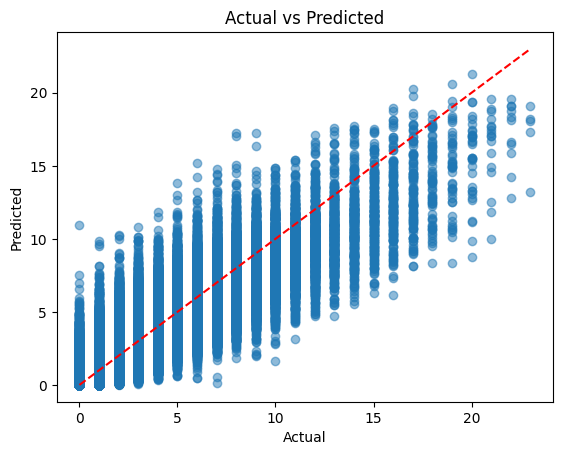

In [152]:
# Plot predicted vs actual:
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

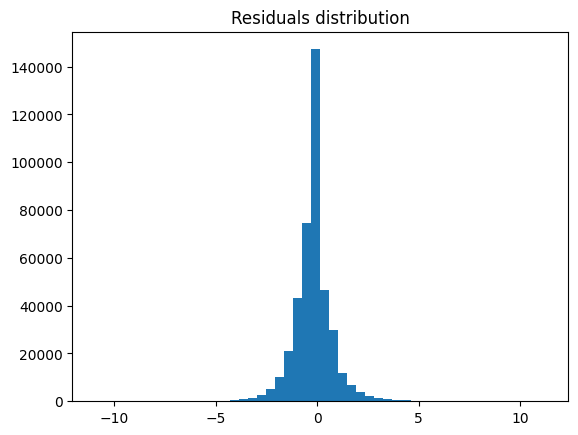

In [154]:
# Residual analysis:
residuals = y_val - y_pred
plt.hist(residuals, bins=50)
plt.title('Residuals distribution')
plt.show()

### Predict on test set

In [157]:
preds = best_model.predict(X_test)

# Round predictions
preds = preds.round().astype(int)

# Final submission
order_days_prediction = pd.DataFrame({
    'account_id': account_ids,
    'prediction': preds
})
order_days_prediction

,account_id,prediction
0,BR_04794747101,3
1,BR_86544809551,3
2,BR_42671910000146,2
3,BR_29856119000142,2
4,BR_17261661009987,1
...,...,...
57360,BR_30398656000175,0
57361,BR_01248390377,0
57362,BR_03803067863,0
57363,BR_49558358487,0


In [159]:
order_days_prediction[order_days_prediction['account_id']=='BR_04794747101']

,account_id,prediction
0,BR_04794747101,3
20388,BR_04794747101,2
40958,BR_04794747101,4


In [160]:
order_days_prediction[order_days_prediction['account_id']=='BR_86544809551']

,account_id,prediction
1,BR_86544809551,3
7026,BR_86544809551,3
8324,BR_86544809551,2
24780,BR_86544809551,8


In [161]:
order_days_prediction.drop_duplicates('account_id',keep='last',inplace=True)
order_days_prediction.reset_index(drop=True, inplace=True)
order_days_prediction.shape

(32944, 2)

In [162]:
order_days_prediction[order_days_prediction['account_id']=='BR_04794747101']

,account_id,prediction
17029,BR_04794747101,4


In [163]:
order_days_prediction[order_days_prediction['account_id']=='BR_86544809551']

,account_id,prediction
8458,BR_86544809551,8


In [164]:
order_days_prediction.head()

,account_id,prediction
0,BR_29604154000174,12
1,BR_49592491534,13
2,BR_09050591000186,10
3,BR_17052896000155,0
4,BR_36217539000144,5


### Save the predicts into csv

In [165]:
order_days_prediction.to_csv('order_days_prediction.csv', index=False)

In [166]:
# To download from google colab into local
files.download('order_days_prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Question 2: Explore the distribution of the order days

### 2a. Can you describe the distribution of the number of order days of a user (or a group of users) via a known probability distribution?
### Propose a formula/density function and explain your solution.


**Verify variance and mean samples**

In [167]:
historical_sorted_df.head(2)

,account_id,order_date,day,month,year,transaction_amount,total_transaction_amount_month,avg_order_days_per_month,avg_days_between_orders,typical_order_period,orders_so_far,target
0,BR_50378490478,2021-01-02,2,1,2021,109.80,329.40,2.82,10.55,2,1,2
1,BR_49658982000100,2021-01-02,2,1,2021,1185.44,4414.88,3.42,8.92,2,1,4


In [168]:
# Count DISTINCT order-days per account-month
monthly_counts = (
    historical_sorted_df.groupby([
      "account_id", historical_sorted_df["order_date"].dt.to_period("M")])
      ["order_date"]
      .nunique()
      .reset_index(name="order_days")
)
monthly_counts

,account_id,order_date,order_days
0,BR_00000343803,2021-01,4
1,BR_00000343803,2021-02,2
2,BR_00000343803,2021-03,3
3,BR_00000343803,2021-04,1
4,BR_00000343803,2021-05,3
...,...,...,...
416386,BR_99946866587,2022-05,2
416387,BR_99946866587,2022-06,2
416388,BR_99946866587,2022-07,3
416389,BR_99980878134,2021-05,3


In [174]:
# Descriptive stats
mean_cnt = monthly_counts["order_days"].mean()
var_cnt  = monthly_counts["order_days"].var(ddof=0)

print(f"Sample mean = {mean_cnt:.3f}")
print(f"Sample var = {var_cnt:.3f}")

if var_cnt > mean_cnt:
    print("Variance > mean, then data are over-dispersed and Poisson is\
 too restrictive.")
else:
    print("Variance ≤ mean, then Poisson might suffice (no strong\
 over-dispersion).")

Sample mean = 3.430
Sample var = 4.990
Variance > mean, then data are over-dispersed and Poisson is too restrictive.


The variable I am modelling is the number of distinct order-days per account in a given month. These are non-negative integers, so we need a count distribution.

I first considered a **Poisson distribution**, which is standard for modelling counts. But when I looked at the historical data and compute the variance and mean, I noticed that variance = 4.99 is larger than the mean = 3.43. This shows over-dispersion and it means that Poisson would underestimate the spread in the data.

To account for that, I chose the **Negative Binomial distribution**, which is commonly used when variance is greater than the mean. It has an extra parameter that adjusts the dispersion.

Therefore, the data are counts with moderate over-dispersion, so Negative Binomial is a better fit than Poisson.

### 2b. How could you estimate the parameter/s of this function?

I could use a method based on the historical data.

In particular, the method of moments which let us estimate the two parameters using the sample mean and variance:

* Mean (from data): 3.43  
* Variance (from data): 4.99

From that, I would calculate:

* $\hat{p} = \text{mean} \div \text{variance}$  
* $\hat{r} = \text{mean} \times \hat{p} \div (1 - \hat{p})$

Using Python, the result is:

In [180]:
mean_k = 3.430
var_k = 4.990

p_hat = mean_k / var_k
r_hat = mean_k * p_hat / (1 - p_hat)

print("So, the fitted Negative Binomial distribution has parameters:")
print(f"r̂ = {r_hat:.3f}")
print(f"p̂ = {p_hat:.3f}")

So, the fitted Negative Binomial distribution has parameters:
r̂ = 7.542
p̂ = 0.687


### 2c. Given the formula/density function, propose a simple way to calculate the probability of having more than 4 days of orders.

With Negative Binomial parameters, I can estimate how likely it is for an account_id to have more than 4 order-days in a month.

I would use the formula:

$$
P(K > 4) = 1 - P(K \leq 4)
$$

Using Python and `scipy.stats.nbinom`, the result is:

In [188]:
from scipy.stats import nbinom

# p_hat = 0.687
# r_hat = 7.54
prob = 1 - nbinom.cdf(4, r_hat, p_hat)
print(f"Probability for K > 4: {prob:.4f}")

Probability for K > 4: 0.2771


### 2d. We want to estimate the time between days of orders. Propose a formula that can estimate this time.

If we assume that order-days follow a random process over time like a Poisson process, then the time between order-days can be approximated by an exponential distribution.

To estimate that, I looked at the average gap between order-days for each account.

Using Python, the code is:

In [189]:
hist_sorted = historical_sorted_df.sort_values(["account_id", "order_date"])
gaps = (
    hist_sorted
    .groupby("account_id")["order_date"]
    .diff()
    .dropna()
    .dt.days
)

avg_gap = gaps.mean()
lambda_hat = 1 / avg_gap
print(f"Average gap = {avg_gap:.0f} days and  λ ≈ {lambda_hat:.4f}")

Average gap = 10 days and  λ ≈ 0.0980
